<a href="https://colab.research.google.com/github/JBalbuenaG/proyecto_DL/blob/main/2_FER2013_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# En esta parte se estan cargando los directorios correspondientes a las 
# imagenes del affectnet tanto el conjunto de entrenamiento como el de 
# validación
train_path = '/content/drive/My Drive/Proyecto_DL/dataset_fer2013/train'
valid_path = '/content/drive/My Drive/Proyecto_DL/dataset_fer2013/test'
train_image_files = glob(train_path +'/*/*.jpg')
valid_image_files = glob(valid_path +'/*/*.jpg')

In [8]:
# Se imprimen para verificar los directorios, existen 6 clases
folders = glob(train_path + '/*')
print(folders)

['/content/drive/My Drive/Proyecto_DL/dataset_fer2013/train/4', '/content/drive/My Drive/Proyecto_DL/dataset_fer2013/train/3', '/content/drive/My Drive/Proyecto_DL/dataset_fer2013/train/2', '/content/drive/My Drive/Proyecto_DL/dataset_fer2013/train/5', '/content/drive/My Drive/Proyecto_DL/dataset_fer2013/train/0', '/content/drive/My Drive/Proyecto_DL/dataset_fer2013/train/1']


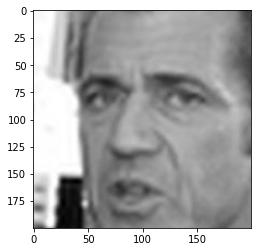

In [9]:
# Muestra una imagen aleatoria de prueba 
plt.imshow(image.load_img(np.random.choice(valid_image_files)))
plt.show()

In [10]:
# Se setean los paramtros para la carga del modelo pre-entrenado por tensorflow
# se usa un tamaño de imagen de 200x200, puesto que algunas imagenes del affecnet son
# muy grandes

# Adicionalmente, se le solicita que cargue los pesos del la red entrenada con el 
# imagenet y sin incluir las ultimas capas densas

IMAGE_SIZE = [200,200]
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights='imagenet',
    include_top=False)

ptm.trainable = False #Se setea para no entrenar los pesos de las CNN, esto tomaría más tiempo

94773248/94765736 [==============================] - 1s 0us/step


In [12]:
#Se crea un modelo que genera el vector caracteristico de la arquitectura pre-entrenada

K = len(folders) #La cantidad de folders en el directorio nos indica la cantidad de clases
x = AveragePooling2D()(ptm.output) # Se agrega un Average Pooling para reducir las caracteristicas finales de la ResNet
x = Flatten()(x) #Se incluye un Flatten para obtener el vector caracteristico producto de la ResNet

model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [13]:
# ACTIVAR SOLO LA PRIMERA VEZ
#Se crea un Image Generator para incluir el pre-procesamiento de imagenes correspondiente a la arquitectura ResNet
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
# ACTIVAR SOLO LA PRIMERA VEZ
#Se crean los generadores deimagenes a partir  de los directorios
# con un batch-size de 128
batch_size = 128

#Generador para el conjunto de entrenamiento
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)
# Generador para el conjunto de validación
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

Found 21708 images belonging to 6 classes.
Found 2982 images belonging to 6 classes.


In [15]:
# ACTIVAR SOLO LA PRIMERA VEZ
# En esta etapa se crean vectores para guardar los vectores caracteristicos producidos
# por los conjuntos de validación y entrenamiento.
# Este procedimiento
N_train = len(train_image_files)
N_valid = len(valid_image_files)

# Se determina la dimensión de salida de la ResNet para el tamaño los array
feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

X_train = np.zeros((N_train,D))
Y_train = np.zeros(N_train)
X_valid = np.zeros((N_valid,D))
Y_valid = np.zeros(N_valid)

In [ ]:
# ACTIVAR SOLO LA PRIMERA VEZ
i = 0
for x, y in train_generator:
    # se obtiene el vector caracteristico de las muestras del batch
    features = model.predict(x)
    sz = len(y) #numero de muestras 
    X_train[i:i+sz]=features
    Y_train[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_train:
        print('breaking now')
        break

print(i)

In [ ]:
# ACTIVAR SOLO LA PRIMERA VEZ
# Se guardan los numpy array correspondientes al conjunto de entrenamiento del affecte 
# con los vecotres caracteristicos de las ResNet
np.save('/content/drive/My Drive/Proyecto_DL/vectors/X_train_fer20132ResNet50.npy', X_train)
np.save('/content/drive/My Drive/Proyecto_DL/vectors/Y_train_fer20132ResNet50.npy', Y_train)

In [ ]:
# ACTIVAR SOLO LA PRIMERA VEZ
# Se realiza el mismo procedimiento anterior para el conjunto de validación
i = 0
for x, y in valid_generator:
    features = model.predict(x)
  
    sz = len(y) 
    X_valid[i:i+sz]=features
    Y_valid[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_valid:
        print('breaking now')
        break

print(i)

In [ ]:
# ACTIVAR SOLO LA PRIMERA VEZ
# Se guardan los numpy array correspondientes al conjunto de entrenamiento del affecte 
# con los vectores caracteristicos de las ResNet
np.save('/content/drive/My Drive/Proyecto_DL/vectors/X_valid_fer20132ResNet50.npy', X_valid)
np.save('/content/drive/My Drive/Proyecto_DL/vectors/Y_valid_fer20132ResNet50.npy', Y_valid)

In [ ]:
# Se cargan todos los vectores caracteristicos del conjunto de validación y entrenamiento
X_train = np.load('/content/drive/My Drive/Proyecto_DL/vectors/X_train_fer20132ResNet50.npy')
Y_train = np.load('/content/drive/My Drive/Proyecto_DL/vectors/Y_train_fer20132ResNet50.npy')
X_valid = np.load('/content/drive/My Drive/Proyecto_DL/vectors/X_valid_fer20132ResNet50.npy')
Y_valid = np.load('/content/drive/My Drive/Proyecto_DL/vectors/Y_valid_fer20132ResNet50.npy')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

#Definición para el calculo de metricas multi-clase
def calculo_metricas(CM, emociones):
    
    emocion = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []
    
    total = np.sum(CM)
    
    for i in range(len(emociones)):
       
        TP = CM[i][i]
        FP = sum(CM[:,i])-TP
        FN = sum(CM[i,:])-TP
        TN = total - TP-FN-FP
        a = (TP+TN)/(TP+TN+FN+FP)
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        f = 2*(r*p)/(r+p)
        
        emocion.append(emociones[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)
    
    metricas = pd.DataFrame()
    metricas['Emociones']=emocion
    metricas['Accuracy']=acc
    metricas['Precision']=prec
    metricas['Recall']=recall
    metricas['F1-Score']=f1
    
    return metricas

def graf_confusion_matrix(CM, emociones,emb):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(CM,annot=True,fmt='',xticklabels=emociones,yticklabels=emociones, ax=ax, cmap='Blues');
    ax.set_title('Matriz de confusión '+emb);
    ax.set_xlabel('Valores Predecidos');
    ax.set_ylabel('Valores Verdaderos');
    
def graficar_historia_entrenamiento(log, metric='accuracy'):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(log.history['val_loss'], label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history[metric], label='train')
    ax2.plot(log.history['val_'+metric], label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel(metric)
    #ax2.set_ylim((0.0, 1.0))
    for ax in axes: ax.legend()

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

tf.keras.backend.clear_session()

#Callabacks
patience = 10
early_stop = EarlyStopping('val_loss',patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss',factor=0.1, patience=int(patience/4), verbose=1)
callbacks = [early_stop, reduce_lr]

feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

#Modelo de red neuronal para clasificación multiclase
i = Input(shape=(D,))
# x = Dense(2048, activation='relu')(i)
# x = Dropout(0.2)(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(6, activation='softmax')(x)

x = Dense(256, activation='relu')(i)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)

emo_model = Model(i ,x)

# entrenado con metrica 'accuracy' o 'tf.keras.metrics.sparse_categorical_accuracy'
emo_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics= tf.keras.metrics.sparse_categorical_accuracy
)

In [5]:
r = emo_model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=20,
    callbacks=callbacks,
    validation_data=(X_valid,Y_valid)
)

NameError: ignored

In [4]:
graficar_historia_entrenamiento(r, metric='sparse_categorical_accuracy')

NameError: ignored

In [ ]:
p = emo_model.predict(X_valid)
pred = np.argmax(p, axis=1)

In [ ]:
Y_valid = Y_valid.astype(int)

In [2]:
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 3: 'fear', 4: 'disgust-contempt', 5: 'anger'}
emociones_1 = list(emo_dict.values())

CM_ResNet = confusion_matrix(Y_valid, pred)
graf_confusion_matrix(CM_ResNet, emociones_1 ,'ResNet50')

NameError: ignored

In [3]:
m1 = calculo_metricas(CM_ResNet, emociones_1)
m1

NameError: ignored

In [1]:
m1.mean()

NameError: ignored

In [ ]:
emo_model.save('top_ResNet50_FER2013_emotions_1.h5')